In [21]:
import gzip
import scipy.io
import scipy.sparse
import pandas as pd
import loompy
import os
import matplotlib.pyplot as plt
from pybloom_live import BloomFilter
import time

In [7]:
def saveFilesIntoFormats(file):
    mtxgz = file + ".mtx.gz"
    # Load .mtx.gz matrix
    with gzip.open(mtxgz, "rt") as f:
        sparse_matrix = scipy.io.mmread(f).tocoo()  # initially COO format

    feat = file + "_features.tsv.gz"
    bar = file + "_barcodes.tsv.gz"
    # Load features and barcodes
    features = pd.read_csv(feat, header=None, sep="\t")
    barcodes = pd.read_csv(bar, header=None)
    
    # Convert to CSR/CSC
    csr_matrix = sparse_matrix.tocsr()
    csc_matrix = sparse_matrix.tocsc()

    mtx = file + ".mtx"
    # Save as uncompressed .mtx
    scipy.io.mmwrite(mtx, sparse_matrix)
    
    # Save as .loom file
    # Transpose to genes × cells (loom format expects rows=features, cols=cells)
    matrix_for_loom = csr_matrix
    
    # Name columns for loom format
    row_attrs = {"Gene": features[0].values}
    col_attrs = {"CellID": barcodes[0].values}

    looom = file + ".loom"
    loompy.create(looom, matrix_for_loom, row_attrs, col_attrs)

    csr = file + "_csr.npz"
    csc = file + "_csc.npz"
    # Save CSSR/CSC as .npz file
    scipy.sparse.save_npz(csr, csr_matrix)
    scipy.sparse.save_npz(csc, csc_matrix)

In [8]:
# === Save Files onto Disk ===
files = ["human", "mouse", "rat"]
for f in files:
   saveFilesIntoFormats(f)

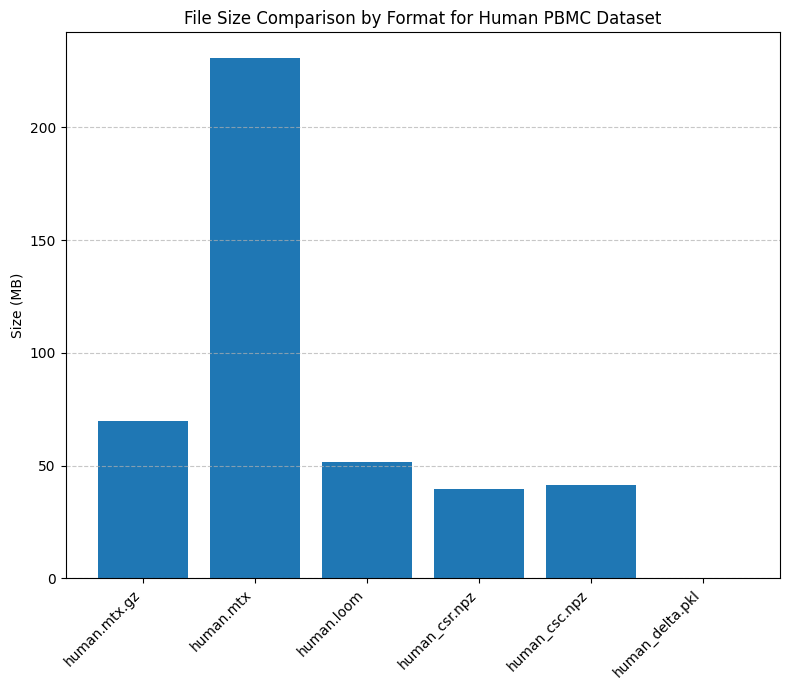

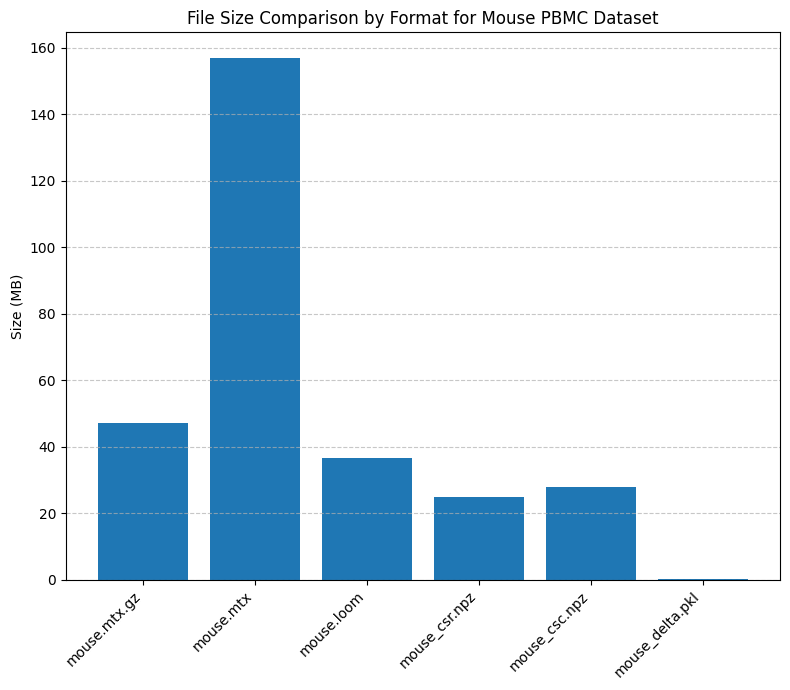

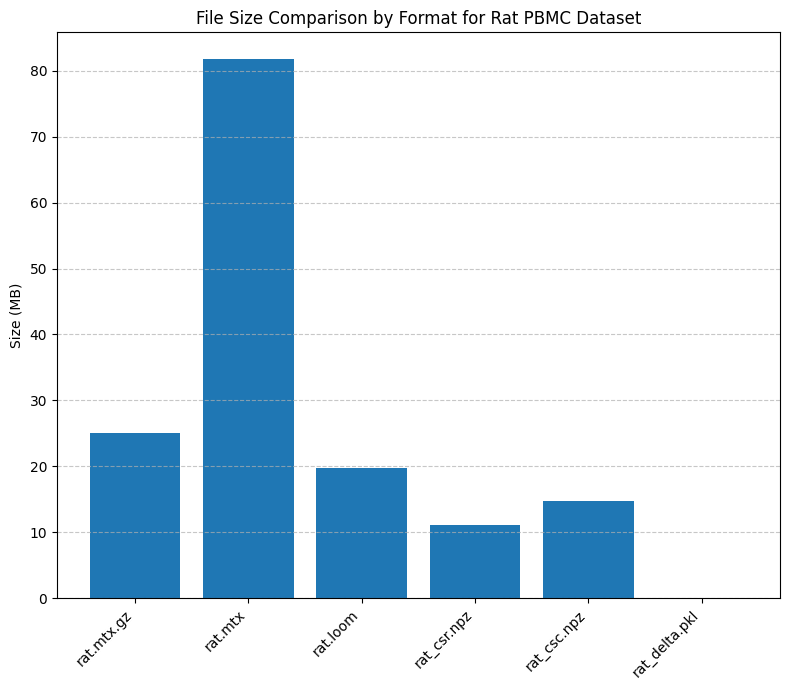

In [19]:
# === Step 1: Define your filenames ===
extensions = [".mtx.gz", ".mtx", ".loom", "_csr.npz", "_csc.npz", "_delta.pkl"]

for f in files:
    fz = [f + ex for ex in extensions]
    # === Step 2: Get file sizes in MB ===
    sizes_mb = [os.path.getsize(f) / 1024**2 for f in fz]
    # === Step 3: Plot bar chart ===
    plt.figure(figsize=(8, 7))
    plt.bar(fz, sizes_mb)
    plt.ylabel("Size (MB)")
    plt.title("File Size Comparison by Format for " + f.capitalize() + " PBMC Dataset")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [23]:
conv = []

start = time.time()
with gzip.open("human.mtx.gz", "rt") as f:
    sparse_matrix = scipy.io.mmread(f).tocoo()  # initially COO format
end = time.time()

coo = end - start
# Load .mtx.gz matrix

# Load features and barcodes
features = pd.read_csv("human_features.tsv.gz", header=None, sep="\t")
barcodes = pd.read_csv("human_barcodes.tsv.gz", header=None)

# Convert to CSR/CSC
start = time.time()
csr_matrix = sparse_matrix.tocsr()
scipy.sparse.save_npz("human_csr.npz", csr_matrix)
end = time.time()
conv.append(end - start + coo)

start = time.time()
csc_matrix = sparse_matrix.tocsc()
scipy.sparse.save_npz("human_csc.npz", csc_matrix)
end = time.time()
conv.append(end - start + coo)

start = time.time()
# Save as uncompressed .mtx
scipy.io.mmwrite("human.mtx", sparse_matrix)
end = time.time()
conv.append(end - start + coo)

# Save as .loom file
# Transpose to genes × cells (loom format expects rows=features, cols=cells)
start = time.time()
matrix_for_loom = csr_matrix
# Name columns for loom format
row_attrs = {"Gene": features[0].values}
col_attrs = {"CellID": barcodes[0].values}
loompy.create("human.loom", matrix_for_loom, row_attrs, col_attrs)
end = time.time()
conv.append(end - start + coo)

In [30]:
conv

[5.334091901779175,
 5.852643728256226,
 1.1227760314941406,
 5.192251205444336,
 352.69]

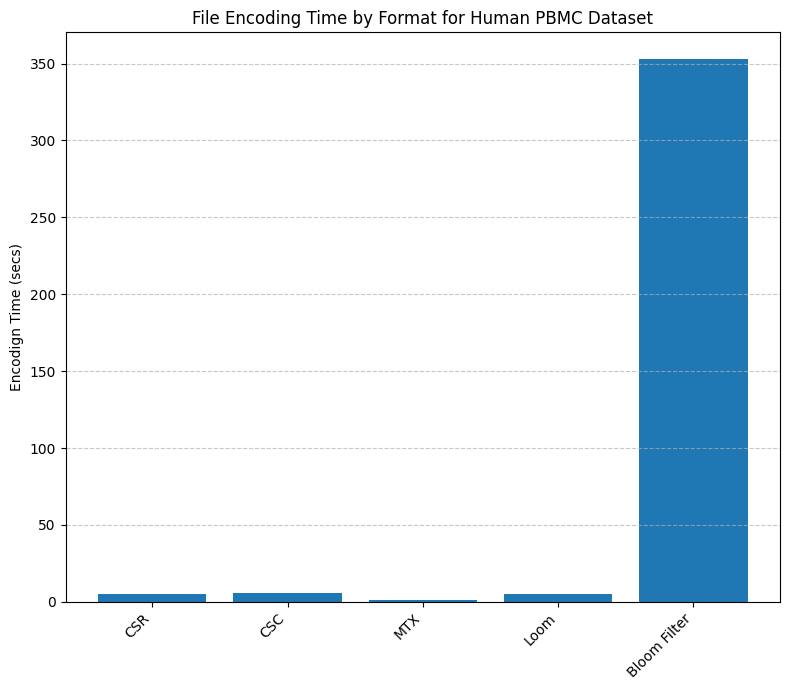

In [31]:
exts = ["CSR", "CSC", "MTX", "Loom", "Bloom Filter"]
plt.figure(figsize=(8, 7))
plt.bar(exts, conv)
plt.ylabel("Encodign Time (secs)")
plt.title("File Encoding Time by Format for Human PBMC Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()